# Importing packages and data

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# scikit learn packages 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer # vectorizer
from sklearn.model_selection import train_test_split # For splitting into test and train data
from sklearn.naive_bayes import MultinomialNB # Simple model for multinomial classification
from sklearn.linear_model import SGDClassifier # SGD classifier - better model for classification
from sklearn.pipeline import Pipeline # Pipeline framework
from sklearn import metrics # For metric evaluation 
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV # Library that allows optimization of hyperparameters
from sklearn.model_selection import cross_validate # For cross validation

In [2]:
# Path to the data
data_ghelms = "/Users/gustavhelms/Documents/Cognitive Science/5_semester/Bachelor/political_polarization/Folketinget-Scraping/data/folketinget_2019_2021_raw.csv"
data_mrg = "./data/folketinget_2019_2021_raw.csv"
# Importing data - only a subset 
#df = pd.read_csv(data_ghelms)
df = pd.read_csv(data_mrg)

# Inspecting the data

In [8]:
df['Parti'].value_counts()

Socialdemokratiet              11194
Venstre                         9737
Dansk Folkeparti                8793
Socialistisk Folkeparti         5496
Enhedslisten                    5181
Radikale Venstre                4044
Nye Borgerlige                  3503
Det Konservative Folkeparti     2361
Alternativet                    2190
Liberal Alliance                2150
Socialdemokraterne               366
Name: Parti, dtype: int64

In [10]:
df.shape

(47037, 14)

In [12]:
df.head(4)

,Title,id,Samling,Nr,Titel,Dato,speaker_id,text,Date,doc_id,Name,Year,Period,Parti
0,Adsbøl,20201_M108_referat,20201,108,"Referat af møde 108 den 4. maj, 2021 kl. 13.00",04-05-2021,42762,"der fik i lige reddet mig . ja, det var en spæ...",2021-05-04T20:12:00Z,36438,Karina Adsbøl,2021,2019-,Dansk Folkeparti
1,Adsbøl,20201_M108_referat,20201,108,"Referat af møde 108 den 4. maj, 2021 kl. 13.00",04-05-2021,42788,jeg vil så gerne blive lidt længere . men vi g...,2021-05-04T20:24:00Z,36466,Karina Adsbøl,2021,2019-,Dansk Folkeparti
2,Ahlers,20201_M114_referat,20201,114,"Referat af møde 114 den 11. maj, 2021 kl. 14.30",11-05-2021,45782,hvis hr. tommy ahlers var gået ind i forhandli...,2021-05-11T17:05:00Z,39795,Tommy Ahlers,2021,2019-,Venstre
3,Aki-Matilda Høegh-Dam,20201_M110_referat,20201,110,"Referat af møde 110 den 6. maj, 2021 kl. 10.00",06-05-2021,44397,"vi behandler i dag et beslutningsforslag, hvor...",2021-05-06T14:32:00Z,38255,Aki-Matilda Høegh-Dam,2021,2019-,Siumut


## Pipeline

In [14]:
pipe_SGD = Pipeline([
('vect', TfidfVectorizer(ngram_range=(1,2), use_idf=True)),
('SGD', SGDClassifier(n_jobs=-1,
                      loss='log', 
                      penalty='l2', 
                      shuffle=True,
                      alpha=1e-2,
                      class_weight = 'balanced'))])

In [42]:
pipe_SGD.get_params();

In [76]:
# define hyper parameters to optimize
param_SGD = {
    'vect__ngram_range': [(1, 2), (1, 3)], # bigrams or trigrams
    'vect__use_idf': (True, False), # use inverse document frequency or not
    'SGD__loss': ('log', 'hinge'),
    'SGD__alpha': (1e-2, 1e-3, 1e-4), # learning rate
    'SGD__class_weight': ("balanced", None)} # balancing class (accounting for classes with low sample size)

In [16]:
# define gridsearch
grid_SGD = GridSearchCV(estimator = pipe_SGD,
                        param_grid = {'SGD__alpha': (1e-2, 1e-3, 1e-4, 1e-5, 1e-6)}, # passing previously defined parameters
                        cv=3, # number of cross validations
                        scoring={'kappa_score': make_scorer(cohen_kappa_score)},
                        refit='kappa_score',
                        return_train_score=True,
                        n_jobs=2) # use 2 processes

In [46]:
df.head(1)

,Title,id,Samling,Nr,Titel,Dato,speaker_id,text,Date,doc_id,Name,Year,Period,Parti
0,Adsbøl,20201_M108_referat,20201,108,"Referat af møde 108 den 4. maj, 2021 kl. 13.00",04-05-2021,42762,"der fik i lige reddet mig . ja, det var en spæ...",2021-05-04T20:12:00Z,36438,Karina Adsbøl,2021,2019-,Dansk Folkeparti


In [12]:
df2019 = df[df['Year'] == 2019][:500]
df2020 = df[df['Year'] == 2020][:500]
df2021 = df[df['Year'] == 2021][:500]
df1500 = pd.concat([df2019, df2020, df2021])

In [13]:
df1500.value_counts('Year')

Year
2019    500
2020    500
2021    500
dtype: int64

In [17]:
# fit the model

X, y = df1500["text"], df1500["Parti"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify = df1500["Parti"])
# I split it into train/test because without the split, the confusion matrix does not make sense... 
# Without splitting, it seems like everything is predicted correctly

grid_SGD.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('SGD',
                                        SGDClassifier(alpha=0.01,
                                                      class_weight='balanced',
                                                      loss='log',
                                                      n_jobs=-1))]),
             n_jobs=2,
             param_grid={'SGD__alpha': (0.01, 0.001, 0.0001, 1e-05, 1e-06)},
             refit='kappa_score', return_train_score=True,
             scoring={'kappa_score': make_scorer(cohen_kappa_score)})

In [92]:
y_pred = grid_SGD.predict(X_test)

In [93]:
set(y_test) - set(y_pred) # see if one dataset contains labels not in the other

set()

In [82]:
grid_SGD.best_score_

0.7064566397632704

In [87]:
# inspect results
results = pd.DataFrame(grid_SGD.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SGD__alpha,param_SGD__class_weight,param_SGD__loss,param_vect__ngram_range,param_vect__use_idf,params,...,split1_test_kappa_score,split2_test_kappa_score,mean_test_kappa_score,std_test_kappa_score,rank_test_kappa_score,split0_train_kappa_score,split1_train_kappa_score,split2_train_kappa_score,mean_train_kappa_score,std_train_kappa_score
0,0.387700,0.020113,0.125937,0.007678,0.01,balanced,log,"(1, 2)",True,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.215528,0.129885,0.183038,0.037894,43,0.929691,0.903347,0.834662,0.889233,0.040058
1,0.335062,0.026830,0.138551,0.010127,0.01,balanced,log,"(1, 2)",False,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.295582,0.200685,0.289600,0.070283,40,0.679564,0.674715,0.618811,0.657697,0.027568
2,0.759936,0.019299,0.175340,0.021705,0.01,balanced,log,"(1, 3)",True,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.061426,0.048704,0.052998,0.005960,46,0.775784,0.753765,0.844156,0.791235,0.038485
3,0.677875,0.022048,0.173188,0.016018,0.01,balanced,log,"(1, 3)",False,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.273689,0.140098,0.249587,0.081363,41,0.708686,0.692892,0.589462,0.663680,0.052875
4,0.309534,0.008776,0.127404,0.006957,0.01,balanced,hinge,"(1, 2)",True,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.694775,0.594393,0.647764,0.041227,8,0.998172,1.000000,1.000000,0.999391,0.000862
5,0.309544,0.007473,0.128431,0.005965,0.01,balanced,hinge,"(1, 2)",False,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.474483,0.388098,0.462963,0.057009,34,0.943719,0.918169,0.954358,0.938749,0.015186
6,0.720545,0.013150,0.182760,0.020016,0.01,balanced,hinge,"(1, 3)",True,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.644231,0.599777,0.627803,0.019915,12,1.000000,1.000000,1.000000,1.000000,0.000000
7,0.669329,0.021943,0.177149,0.016788,0.01,balanced,hinge,"(1, 3)",False,"{'SGD__alpha': 0.01, 'SGD__class_weight': 'bal...",...,0.490277,0.405766,0.468250,0.044819,33,0.967220,0.947335,0.985404,0.966653,0.015547
8,0.324820,0.008862,0.126003,0.002908,0.01,None,log,"(1, 2)",True,"{'SGD__alpha': 0.01, 'SGD__class_weight': None...",...,0.013841,-0.003486,0.003452,0.007483,47,0.153104,0.159852,0.152767,0.155241,0.003263
9,0.327322,0.010335,0.121249,0.009364,0.01,None,log,"(1, 2)",False,"{'SGD__alpha': 0.01, 'SGD__class_weight': None...",...,0.094767,0.052922,0.068569,0.018641,44,0.162724,0.146484,0.186292,0.165167,0.016343


In [88]:
grid_SGD.best_params_

{'SGD__alpha': 0.001,
 'SGD__class_weight': 'balanced',
 'SGD__loss': 'hinge',
 'vect__ngram_range': (1, 2),
 'vect__use_idf': True}

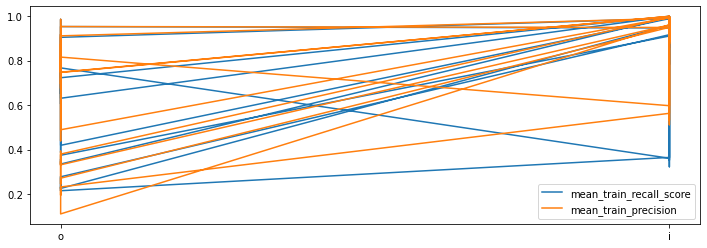

In [25]:
plt.figure(figsize=(12,4))
df_train = pd.DataFrame(grid_SGD.cv_results_)
for score in ['mean_train_recall_score', 'mean_train_precision']:
    
    plt.plot([_[1] for _ in df_train['param_SGD__loss']], ##this fucks it up, and alphas are not subscriptable, same for "None" in class weights
             df_train[score],
             label=score)
plt.legend();

In [233]:
# how does SGD rank models?
sgd = SGDClassifier();
??sgd.score

In [40]:
# look intro metrics for multilabel classification
import webbrowser
webbrowser.open('https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd')

True

## NOTES ON METRICS

#### Precision Score: TP / (TP + FP)
Precision Score measures the correct predictions within a class compared to total predictions of that class. 
If the algorithm predict Venstre 10 times, and 3 of those af False Positives, the Precision Score is: 
7 / (7 + 3) = 0,7. 


#### Recall Score: TP / (TP + FN)
Recall Score measures how many of the total true labels was "found" by the algorithm.
If the algorithm predicts Venstre 10 times, but there are a total of 15 occurences of Venstre in y_test, the Recall Score is: 
10 / (10 + 5)

#### F1 Score
F1 is a harmonic mean of Precision and Recall. 

F1 Score: (2 * (Precision * Recall)) / (Precision + Recall)

#### Simple Accuracy: True Predictions / No. of predictions

Simply: How many samples did the algorithm label correctly as a proportion of total attempts. 

#### Cohen's Kappa

"Super charged version of simple accuracy", taking into account class imbalances.

Sounds very much like our best bet. Intuitively, I would have thought simple accuracy would be the best. But the imbalances in our dataset are big, so this makes really good sense.

Formula: 

k = (p_0 - p_e) / (1 - p_e) 

p_0: Simple accuracy
p_e: The probability of y_pred and y_true to be equal by chance. This is what takes into account class imbalance.

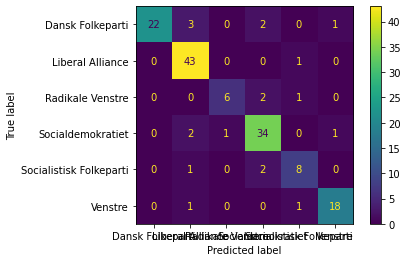

In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(grid_SGD, X_test, y_test)
plt.show()

Text(69.0, 0.5, 'Truth')

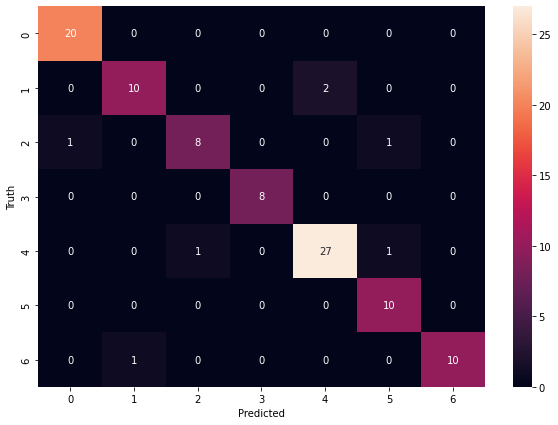

In [94]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn

y_pred = grid_SGD.predict(X_test)# documentation says the best model is used for prediction
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
accuracy_score(y_test, y_predicted)
precision_score(y_test, y_predicted, average='weighted')

0.609576017134821

In [32]:
# pipeline, params and grid
pipe_SGD = Pipeline([
('vect', TfidfVectorizer(ngram_range=(1,2), use_idf=True)), #
('SGD', SGDClassifier(n_jobs=-1,
                      loss='log', 
                      penalty='l2', 
                      shuffle=True,
                      alpha=1e-2,
                      class_weight = 'balanced'))])

param_SGD = {
    'vect__ngram_range': [(1, 2), (1, 3)], # bigrams or trigrams
    'vect__use_idf': (True, False), # use inverse document frequency or not
    'SGD__loss': ('log', 'hinge'),
    'SGD__alpha': (1e-2, 1e-3, 1e-4), # learning rate
    'SGD__class_weight': ("balanced", None)} # balancing class (accounting for classes with low sample size)

grid_SGD = GridSearchCV(estimator = pipe_SGD,
                        param_grid = param_SGD, # passing previously defined parameters
                        cv=3,
                        scoring={'precision': make_scorer(precision_score, average='weighted'), 
                                 'recall_score': make_scorer(recall_score, average='weighted'),
                                 'kappa_score': make_scorer(cohen_kappa_score)},
                        refit='precision',# number of cross validations
                        n_jobs=2) # use 2 processes (usually all available processes)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
No handles with labels found to put in legend.
No handles with labels found to put in legend.


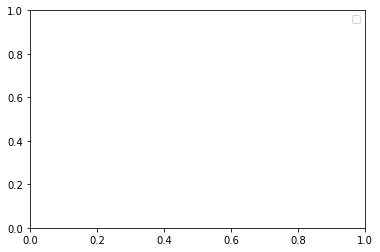

In [35]:
# loop through years and fit/predict per year, append scores and so on
df = pd.read_csv(data_mrg)

best_scores = []
best_params = []
precision_scores = []
accuracy_scores = []

for year in df.Year.unique():
    subset = df[df['Year'] == year][:1000]
    X, y = subset["text"], subset["Parti"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify = subset["Parti"])
    grid_SGD.fit(X_train, y_train)
    df_train = pd.DataFrame(grid_SGD.cv_results_)
    plt.legend()
    
    # save best kappa score and params generating that score
    best_scores.append(grid_SGD.best_score_)
    best_params.append(grid_SGD.best_params_)
    
    # metrics on test set
    y_pred = grid_SGD.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))

In [36]:
precision_scores

[0.9073809523809523, 0.9231038961038961]

In [39]:
best_params

[{'SGD__alpha': 0.0001,
  'SGD__class_weight': None,
  'SGD__loss': 'hinge',
  'vect__ngram_range': (1, 2),
  'vect__use_idf': True},
 {'SGD__alpha': 0.001,
  'SGD__class_weight': 'balanced',
  'SGD__loss': 'hinge',
  'vect__ngram_range': (1, 2),
  'vect__use_idf': True}]

## Comments

------------ Initial notes fra Morten ---------------
Jeg tror vi skal huske på, som vi snakkede om, at selve performance af modellen svarer til vores mål for polarisering.
Så hvis vi "p-hacker" vores model fortolkes det senere hen som en højere polarisering.

Det ændrer lidt den måde jeg synes vi skal tænke på mht. GridSearch fx. 
Beslutningen om ngrams burde ikke være baseret på det, der genererer "højst polarisering". 
Hvad beslutningen så skal baseres på ved jeg ikke helt. Måske konceptuel argumentation. 

Derudover kan du i for loopet ovenover se strukturen at GridSearch optimerer modellen baseret på træningsdata,
og metrics fås så baseret på den optimerede models performance mht. test data. 
Derfor får vi fx én recall score pr. år. 
Er det den score, der bruges som mål for polarisering? I sammenligning med den score, der ligger inde i grid_SGD objektet. 

OBS: Fejlen med "Precision is ill-defined" sker når der er labels i train-sættet som ikke er i test, og derfor ikke bliver predicted. Så vidt jeg kunne læse mig til (https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi).


----- Noter fra Gustav fra gennemgang af script (27/10) --------------

Jeg er også meget i tvivl om vi skal optimire hyperparametrene for hvert år når vi kører den endelige model. Det vil nemlig højst sandsynligt resultere i at vi har forskellige classifiers for hvert år i stedet for bare at køre den samme på alle år. Vi kunne evt. køre en grid search på et subset af dataen og så vælge de hyperparametre som den bedste model i det subset af dataen har og så bruge dem for alle år. Dette ville også få modellen til at køre utrolig meget hurtigere. 

Ting jeg har tilføjet og overvejelser derom: 
- Jeg har tilføjet et stratify argument i train_test_split. 
I forbindelse med at du skrev det med at grunden til at vi fik den error med ill-defined precision kom jeg i tanke om at det er vigtigt at vi beholder distributionen af partier i både test og træningsdataen så ledes at vi ikke lige pludselig ender med et datasæt der tilfældigvis ikke har alle partier repræsenteret. stratify argumentet burde sørge for at dataen bliver splittet således at der er ens distribution i både trænings og test data sættet. 

- Tilføjet cohen_kappa_score som metric i vores model
I den artikel du henviste til anbefalede han at bruge cohen_kappa_score til at tage højde for at vores model ikke blot scorede godt på accuracy by chance. Tidligere så vi at vores model kun gættede Venstre og Socialdemokratiet da disse var de to største partier. Selvom den gjorde dette fik den stadig relativt gode accuracy score fordi at Venstre og Socialdemokratiet udgør en kæmpe stor del af alle taler. cohen_kappa_score tager højde for at classifieren kan ramme rigtigt by chance. På den måde for vi måske en bedre score for hvor godt algoritmen klarer sig. Jeg foreslår at vi bør optimize efter denne og bruger denne i vores analyse efterfølgende. 

- I forbindelse med at bruge train_test_split
Vi bør overveje om det giver mening at bruge train_test_split i vores endelige loop. Jeg tænker umiddelbart at det ikke nødvendigvis giver særlig meget mening. I vores gridsearch bruger vi cross validation der automatisk splitter det datasæt vi har fodret den op i test og trænings sæt 3 gange. De metrics som den evaluere på er egentlig de samme som vi laver efterfølgende. Vi kunne derfor bare fodre den hele datasættet og så bruge accuracy scoren fra den bedste model. Metricen er jo et eller andet form for gennemsnit af evalueringer af de tre forskellige modeller den har lavet i de tre split af dataen. Vi gør det dermed dobbelt op, manuelt og ikke lige så grundigt - Vi har jo egentlig kun 1 random spli (1 cross validation) når vi gøre det på denne måde, hvor den har 3 splits (3 cross validations).   

-- OKAY JEG HAR LIGE LÆST LIDT MERE. Det giver vidst mening at evaluere modellen på et uafhængigt test sæt til sidst. 

# Trying to create a pipeline with cross validation and no parameter search

In [36]:
pipe = Pipeline([
('vect', TfidfVectorizer(ngram_range=(1,2), use_idf=True)), #
('SGD', SGDClassifier(n_jobs=-1,
                      loss='log', 
                      penalty='l2', 
                      shuffle=True,
                      alpha=1e-2,
                      class_weight = 'balanced'))])

In [47]:
scores = {'kappa_scorer': make_scorer(cohen_kappa_score),
                'precision': make_scorer(precision_score, average='weighted')}
scores = cross_validate(pipe, X, y, cv = 5, return_train_score = False, scoring = scores)

/Users/gustavhelms/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavhelms/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavhelms/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavhelms/opt/anaconda3/lib/pyt

In [48]:
pd.DataFrame(scores)

,fit_time,score_time,test_kappa_scorer,test_precision
0,8.522218,1.226586,0.002297,0.088624
1,8.451103,1.319105,0.018223,0.099132
2,8.680622,1.202218,0.000167,0.073801
3,8.477572,1.166378,0.001600,0.049774
4,8.413852,1.233326,0.011661,0.116841
